In [18]:
path = "/kaggle/input/dataset/5_class_problem/"
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
import statsmodels.api as sm
import cv2
import tensorflow as tf
from tensorflow.keras.layers import (Input, Concatenate, GlobalAveragePooling2D, Dense, Dropout)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Recall
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from tensorflow.keras.applications import InceptionResNetV2, DenseNet201


X_train = np.load(path + "nod_training_augmented_images.npy")
y_train = np.load(path + "nod_training_augmented_labels.npy")

X_val = np.load(path + "nod_validation_set.npy")
y_val = np.load(path + "nod_validation_set_labels.npy")

X_test = np.load(path + "nod_test_set.npy")
y_test = np.load(path + "nod_test_set_labels.npy")

# y_train = 0.2 * y_train - 0.1
# y_val = 0.2 * y_val - 0.1
# y_test = 0.2 * y_test - 0.1

# y_train = 0.25 * y_train - 0.25
# y_val = 0.25 * y_val - 0.25
# y_test = 0.25 * y_test - 0.25

from tensorflow.keras.utils import to_categorical

num_classes = 5  # Define the number of classes

# Apply one-hot encoding
y_train = to_categorical(y_train - 1, num_classes)
y_val = to_categorical(y_val - 1, num_classes)


X_train = np.expand_dims(X_train, axis=-1)  # Aggiunge il canale come ultima dimensione
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((4360, 224, 224, 1),
 (4360, 5),
 (237, 224, 224, 1),
 (237, 5),
 (237, 224, 224, 1),
 (237,))

In [11]:
sigma_ratio_value = 5
class GaussianMaskLayer(tf.keras.layers.Layer):
    def __init__(self, sigma_ratio=sigma_ratio_value, **kwargs):
        super(GaussianMaskLayer, self).__init__(**kwargs)
        self.sigma_ratio = sigma_ratio
        self.mask = None  

    def build(self, input_shape):
        h, w = input_shape[1], input_shape[2]
        y, x = tf.meshgrid(tf.range(h, dtype=tf.float32), tf.range(w, dtype=tf.float32), indexing='ij')

        center = (h // 2, w // 2) 
        sigma = tf.cast(min(h, w) / self.sigma_ratio, tf.float32)

        self.mask = tf.exp(-((x - center[1])**2 + (y - center[0])**2) / (2 * sigma**2))
        self.mask = self.mask / tf.reduce_max(self.mask) 
        self.mask = tf.expand_dims(self.mask, axis=-1)  

    def call(self, inputs):
        return inputs * self.mask

    def get_config(self):  # Per salvare e caricare il modello
        config = super().get_config()
        config.update({"sigma_ratio": self.sigma_ratio})
        return config

GML = GaussianMaskLayer()
X_train_masked = GML(X_train)
X_val_masked = GML(X_val)

# Train

In [33]:
def CNN(weight_decay = 1e-5, dropout_rate = 0.5):
    base_model1 = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
    base_model2 = DenseNet201(weights='imagenet', include_top=False, input_shape=(224,224,3))

    input_layer = Input(shape=(224, 224, 1))

    # Sostituisce Lambda con Custom Layer
    rgb_input = Concatenate(axis=-1)([input_layer, input_layer, input_layer])

    x1 = base_model1(rgb_input)
    x1 = GlobalAveragePooling2D()(x1)
    x1 = Dense(16, activation='relu', kernel_regularizer=l2(weight_decay))(x1)

    x2 = base_model2(rgb_input)
    x2 = GlobalAveragePooling2D()(x2)
    x2 = Dense(16, activation='relu', kernel_regularizer=l2(weight_decay))(x2)

    x = Concatenate()([x1, x2])
    x = Dropout(dropout_rate)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(weight_decay))(x)
    x = Dense(32, activation='relu', kernel_regularizer=l2(weight_decay))(x)
    output_layer = Dense(5, activation='softmax', kernel_regularizer=l2(weight_decay))(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CNN')

    for layer in base_model1.layers:
        layer.trainable = False
    for layer in base_model2.layers:
        layer.trainable = False

    return model
model = CNN(weight_decay = 1e-5, dropout_rate= 0.3)


def accuracy_classification(y_true, y_pred):
    # y_true = tf.round(5 * y_true + 0.5)
    # y_pred = tf.round(5 * y_pred + 0.5)
    y_true = tf.round(4 * y_true + 1)
    y_pred = tf.round(4 * y_pred + 1)
    accuracy = tf.equal(y_true, y_pred)
    return tf.reduce_mean(tf.cast(accuracy, tf.float32))


model.compile(
    # loss = 'mae',
    loss = 'categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, weight_decay= 1 * 1e-4),
    metrics=["accuracy"]
)

model.summary()

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_41            │ (None, 224, 224, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_26            │ (None, 224, 224, 3)    │              0 │ input_layer_41[0][0],  │
│ (Concatenate)             │                        │                │ input_layer_41[0][0],  │
│                           │                        │                │ input_layer_41[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_resnet_v2       │ (None, 5, 5, 1536)     │     54,336,736 │ concatenate_26[0][0]   │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ densenet201 (Functional)  │ (None, 7, 7, 1920)     │     18,321,984 │ concatenate_26[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1536)           │              0 │ inception_resnet_v2[0… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1920)           │              0 │ densenet201[0][0]      │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_80 (Dense)          │ (None, 16)             │         24,592 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_81 (Dense)          │ (None, 16)             │         30,736 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_27            │ (None, 32)             │              0 │ dense_80[0][0],        │
│ (Concatenate)             │                        │                │ dense_81[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 32)             │              0 │ concatenate_27[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_82 (Dense)          │ (None, 64)             │          2,112 │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_83 (Dense)          │ (None, 32)             │          2,080 │ dense_82[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_84 (Dense)          │ (None, 5)              │            165 │ dense_83[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 72,718,405 (277.40 MB)

 Trainable params: 59,685 (233.14 KB)

 Non-trainable params: 72,658,720 (277.17 MB)

In [34]:
scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=15, factor=0.5)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode = "max",
    patience=25,
    restore_best_weights=True  # Ripristina i migliori pesi quando il training si interrompe
)

history = model.fit(
    x=X_train_masked,
    y=y_train,
    batch_size=128,
    epochs=80,
    validation_data=(X_val_masked, y_val),
    callbacks=[scheduler, early_stopping], # checkpoint],
).history

Epoch 1/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 154s 3s/step - accuracy: 0.2623 - loss: 1.5814 - val_accuracy: 0.2785 - val_loss: 1.4009 - learning_rate: 0.0010
Epoch 2/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.3752 - loss: 1.3734 - val_accuracy: 0.3966 - val_loss: 1.2389 - learning_rate: 0.0010
Epoch 3/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.4289 - loss: 1.2863 - val_accuracy: 0.4515 - val_loss: 1.2428 - learning_rate: 0.0010
Epoch 4/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.4760 - loss: 1.2138 - val_accuracy: 0.4768 - val_loss: 1.1687 - learning_rate: 0.0010
Epoch 5/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.4775 - loss: 1.1912 - val_accuracy: 0.4852 - val_loss: 1.1524 - learning_rate: 0.0010
Epoch 6/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.4900 - loss: 1.1515 - val_accuracy: 0.4557 - val_loss: 1.1705 - learning_rate: 0.0010
Epoch 7/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.5182 - loss: 1.1234 - val_accuracy:

# Test

8/8 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step 
Accuracy: 0.5359


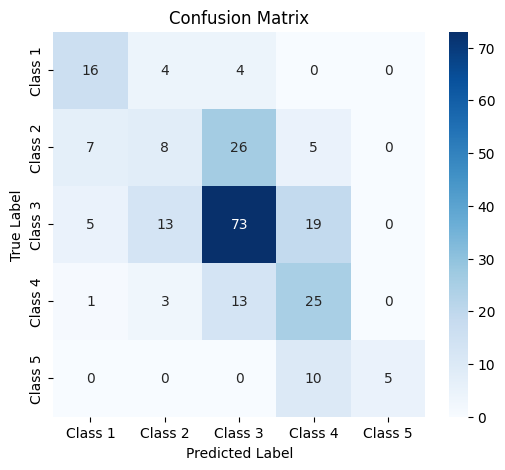

In [35]:
X_test_filtered = GML(X_test)
y_pred_prob = model.predict(X_test_filtered)

# y_true = tf.round(5 * y_test + 0.5)
# y_pred = tf.round(5 * y_pred_prob + 0.5)

# y_true = tf.round(4 * y_test + 1)
# y_pred = tf.round(4 * y_pred_prob + 1)

y_pred = np.argmax(y_pred_prob, axis = 1)

accuracy = accuracy_score(y_test - 1, y_pred)

print(f"Accuracy: {accuracy:.4f}")

cm = confusion_matrix(y_test - 1, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 1', 'Class 2','Class 3', 'Class 4', 'Class 5'], yticklabels=['Class 1', 'Class 2','Class 3', 'Class 4', 'Class 5'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

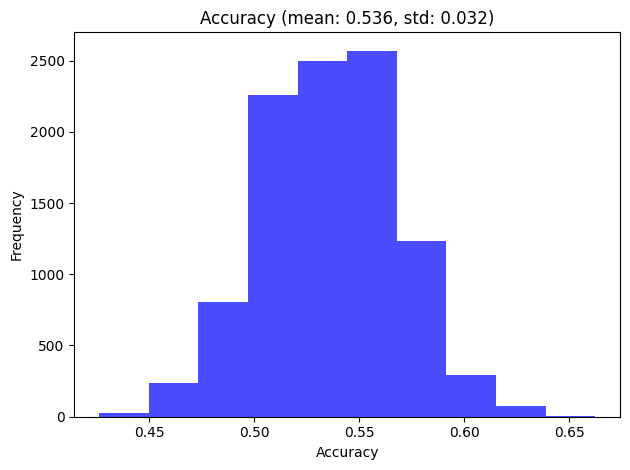

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def bootstrap_metrics(y_pred, y_test, n_iterations=10000):
    accuracy = []

    for _ in range(n_iterations):
        indices = np.random.choice(len(y_test), size=int(len(y_test)), replace=True)
        y_pred_bootstrap = y_pred[indices]
        y_test_bootstrap = y_test[indices]

        accuracy.append(accuracy_score(y_test_bootstrap, y_pred_bootstrap))
    return accuracy

accuracy = bootstrap_metrics(y_pred, y_test - 1)


metrics = {
    'Accuracy': accuracy
}

means = {metric: np.mean(values) for metric, values in metrics.items()}
std_devs = {metric: np.std(values) for metric, values in metrics.items()}


plt.hist(accuracy, alpha=0.7, color='blue')
plt.title(f'Accuracy (mean: {means["Accuracy"]:.3f}, std: {std_devs["Accuracy"]:.3f})')
plt.xlabel('Accuracy')
plt.model.save('model.h5')
ylabel('Frequency')

plt.tight_layout()
plt.show()

In [39]:
model.save('model5classes.keras')

In [ ]:
# Class 4 misclassified as class 1: why? 
idx = 1

sample = X_test_filtered[idx]

from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries
from lime import lime_image


sample_rgb = np.repeat(sample, 3, axis=-1)

def predict_fn(images):
    images_gray = np.mean(images, axis=-1, keepdims=True)  # Convert back to grayscale by averaging the channels
    return model.predict(images_gray, verbose = 0)

explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(sample_rgb, predict_fn, top_labels=5, hide_color=0, num_samples=5000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.imshow(sample[:,:,0], cmap='gray')
plt.title(f"Original, true class = {y_test[idx]}")

plt.subplot(1, 2, 2)
plt.imshow(sample[:,:,0], cmap='gray')
plt.imshow(temp[:,:,0], cmap = "jet", alpha = 0.5)
plt.title(f"Explanation: predicted class = {explanation.top_labels[0] + 1}")
plt.show()

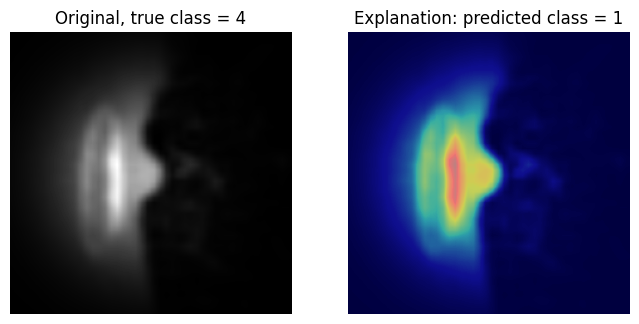

In [109]:
# Class 4 misclassified as class 1: why? 
idx = np.where((y_pred + 1 == 1) & (y_test == 4))[0] # 89
idx = 89

sample = X_test_filtered[idx]

from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries
from lime import lime_image
from sklearn.linear_model import LogisticRegression

sample_rgb = np.repeat(sample, 3, axis=-1)

def predict_fn(images):
    images_gray = np.mean(images, axis=-1, keepdims=True)  # Convert back to grayscale by averaging the channels
    return model.predict(images_gray, verbose = 0)

explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(sample_rgb, predict_fn, num_samples=10000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0])

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.imshow(sample[:,:,0], cmap='gray')
plt.title(f"Original, true class = {y_test[idx]}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(sample[:,:,0], cmap='gray')
plt.imshow(temp[:,:,0], cmap = "jet", alpha = 0.5)
plt.title(f"Explanation: predicted class = {explanation.top_labels[0] + 1}")
plt.axis("off")

plt.show()